In [152]:
import cv2
import torch
from torch import optim
from torch.autograd.functional import jacobian
from PIL import Image
import OpenEXR, Imath
import numpy as np
from matplotlib import pyplot as plt

In [241]:
def construct_xy(H, W, cuda=False):
    xy = torch.zeros(2, H, W)
    if cuda:
        xy = xy.cuda()
    xy[0] = torch.arange(W).reshape(1, W).repeat((H, 1)) # x
    xy[1] = torch.arange(H-1, -1, -1).reshape(H, 1).repeat((1, W)) # y
    return xy

In [242]:
def dist_to_line_2d(xy, c1, c2):
    '''
    Input:
        xy: (2, H, W) torch tensor - xy(h, w) is the coordinate
        c1: (2,) torch tensor - (x,y) of one end
        c2: (2,) torch tensor - (x,y) of another end
    '''
    _, H, W = xy.shape
    xy_c1 = xy - c1.reshape(2,1,1)
    c12 = (c2 - c1).reshape(2,1,1)
    c12_length = c12.norm()
    c12 = c12/c12_length
    closest_dist = torch.clamp(torch.clamp(torch.sum(xy_c1 * c12, dim=0), min=0), max=c12_length)
    closest_pt = c1.reshape(2,1,1) + closest_dist * c12
    dist = torch.norm(xy - closest_pt, dim = 0)
    return dist

In [292]:
def q_to_c_2d(q, H, W, cuda=False):
    l = 10
    n = q.shape[0]-1
    c = torch.zeros((n,2))
    if cuda:
        c = c.cuda()
    c[0, 0] = q[0]
    c[0, 1] = q[1]
    for i in range(1, n):
        c[i, 0] = c[i-1, 0] + l*torch.cos(q[i+1])
        c[i, 1] = c[i-1, 1] + l*torch.sin(q[i+1])
#     print(c)
    return c

In [5]:
def render(q, H, W):
    sigma = 3
    c = q_to_c_2d(q, H, W)
    xy = construct_xy(H, W)
    prev_dist = dist_to_line_2d(xy.clone(), c[0], c[1])
    for i in range(c.shape[0]-1):
        dist = torch.minimum(dist_to_line_2d(xy.clone(), c[i], c[i+1]), prev_dist)
        prev_dist = dist
#     dist = torch.exp(-dist * dist/(sigma**2))
    dist = dist * dist
    return dist

In [329]:
def loss_fn(q, H, W, mask):
    dist = render(q, H, W)
#     plt.imshow(dist[mask].detach().numpy())
#     print(dist[mask].detach().numpy())
#     plt.show()
    return torch.sum(dist[mask])#+torch.sum(-dist[~mask])

In [132]:
def exr_to_np(path):
    y_resolution = 540
    x_resolution = 810
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    
    rgb_exr = OpenEXR.InputFile(path)
    rgb_dw = rgb_exr.header()['dataWindow']
    rgb_size = (rgb_dw.max.x - rgb_dw.min.x + 1, rgb_dw.max.y - rgb_dw.min.y + 1)
    r_str = rgb_exr.channel('R', pt)
    g_str = rgb_exr.channel('G', pt)
    b_str = rgb_exr.channel('B', pt)
    rgb_img = np.zeros((y_resolution, x_resolution, 3))
    r_ch = Image.frombytes("F", rgb_size, r_str)
    g_ch = Image.frombytes("F", rgb_size, g_str)
    b_ch = Image.frombytes("F", rgb_size, b_str)
    rgb_img[: ,:, 2] = np.array(r_ch.getdata()).reshape(y_resolution, x_resolution)
    rgb_img[: ,:, 1] = np.array(g_ch.getdata()).reshape(y_resolution, x_resolution)
    rgb_img[: ,:, 0] = np.array(b_ch.getdata()).reshape(y_resolution, x_resolution)
    min_val = rgb_img.min()
    max_val = rgb_img.max() 
    rgb_img = ((rgb_img - min_val)/(max_val - min_val) * 255.0).astype(np.uint8)
    return rgb_img

In [326]:
class tracker:
    def __init__(self, H, W, cuda=False):
        self.H = H
        self.W = W
        self.cuda = cuda
        
    def set_obs(self, mask, rgb_np=None, subsample=False):
        if subsample:
            N = mask.nonzero().shape[0]
            n = 100
            rand_idx = np.random.choice(N, n)
            sub = torch.zeros_like(mask)
            sub[mask.nonzero()[rand_idx][:, 0], mask.nonzero()[rand_idx][:, 1]] = True
            self.mask = sub
            if self.cuda:
                self.mask = sub.cuda()
        else:
            self.mask = mask
            if self.cuda:
                self.mask = mask.cuda()
        self.rgb_np = rgb_np
        
    def set_init(self, q):
        self.q = q
        if self.cuda:
            self.q = q.cuda()
        
    def dist_fn(self, q):
        sigma = 3
        c = q_to_c_2d(q, self.H, self.W, cuda=self.cuda)
        xy = construct_xy(self.H, self.W, cuda=self.cuda)
        prev_dist = dist_to_line_2d(xy.clone(), c[0], c[1])
        for i in range(c.shape[0]-1):
            dist = torch.minimum(dist_to_line_2d(xy.clone(), c[i], c[i+1]), prev_dist)
            prev_dist = dist
#         dist = torch.exp(-dist * dist/(sigma**2))
        dist = dist[self.mask]
        return dist
        
    def step(self):
        # fwd
        prev_q = self.q.clone()
        changed = False
        step_size = 0.5/self.mask.sum()
        weight_decay = 0.9
        step = 0
        print('---- optimize translation ----')
        while((((prev_q-self.q).norm().item() > 0.5) or not changed) and step < 10):
            prev_q = self.q.clone()
            q_grad = self.q.clone().detach().requires_grad_(True)
            loss = loss_fn(q_grad, H, W, mask)
            print('loss:', loss)
            loss.backward()
            grad = q_grad.grad.clone().detach()
            grad[2:] = 0
            self.q = q_grad.clone().detach()
            self.q -= grad * step_size
            step_size *= weight_decay
            print(self.q)
            print(grad)
            changed = True
            step += 1

        changed = False
        step_size = 10**-5
        weight_decay = 0.9
        step = 0
        print('---- optimize rotation ----')
        while((((prev_q-self.q).norm().item() > 0.5) or not changed) and step < 10):
            prev_q = self.q.clone()
            q_grad = self.q.clone().detach().requires_grad_(True)
            loss = loss_fn(q_grad, H, W, mask)
            loss.backward()
            grad = q_grad.grad.clone().detach()
            self.q = q_grad.clone().detach()
            self.q -= grad * step_size
            step_size *= weight_decay
            print(self.q)
            print(grad)
            changed = True
            step += 1
    
    def gauss_step(self):
        curr_norm = float('Inf')
        while True:
            prev_norm = curr_norm
            J=jacobian(self.dist_fn, self.q)
            dist = self.dist_fn(self.q)
            curr_norm = dist.norm()
            print(self.q)
            print(dist.norm())
#             if curr_norm > prev_norm:
#                 self.q = prev_q
#                 break
            prev_q = self.q.clone()
            try:
                self.q -= torch.mm(torch.mm(torch.mm(J.t(), J).inverse(), J.t()), dist.unsqueeze(1)).squeeze()
            except:
                self.q -= torch.mm(torch.mm(torch.mm(J.t(), J).pinverse(), J.t()), dist.unsqueeze(1)).squeeze()
    
    def lm_step(self):
        pass
            
    def vis(self):
        if self.rgb_np:
            vis_img = self.rgb_np.copy()
        else:
            vis_img = np.zeros((self.H, self.W))

        radius = 3
        color = (255, 0, 0)
        thickness = 2

        c = q_to_c_2d(self.q, self.H, self.W)
        for i in range(c.shape[0]):
            vis_img = cv2.circle(vis_img, (int(c[i][0]), self.H-int(c[i][1])), radius, color, thickness)
        plt.imshow(vis_img)
        plt.show()

In [331]:
# gradient descent sanity check
H = 540
W = 810
simple_tracker = tracker(H, W,cuda=True)
q = torch.zeros((12,))
q[0] = 180
q[1] = 360
simple_tracker.set_init(q)
mask = torch.zeros((H, W), dtype=bool)
mask[200:205, 200:300] = True
simple_tracker.set_obs(mask)
simple_tracker.step()

---- optimize translation ----
loss: tensor(277850., grad_fn=<SumBackward0>)
tensor([181.9000, 337.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000], device='cuda:0')
tensor([-1900., 23000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.], device='cuda:0')
loss: tensor(10078.9102, grad_fn=<SumBackward0>)
tensor([183.2932, 337.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000], device='cuda:0')
tensor([-1548.0012,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000],
       device='cuda:0')
loss: tensor(8088.1084, grad_fn=<SumBackward0>)
tensor([184.3568, 337.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000], device='cuda:0')
tensor([-1313.0859,     0.0000,     0.0000,     0

In [327]:
# gauss-newton method sanity check
H = 540
W = 810
simple_tracker = tracker(H, W,cuda=True)
q = torch.zeros((12,))
q[0] = 180
q[1] = 360
simple_tracker.set_init(q)
mask = torch.zeros((H, W), dtype=bool)
mask[200:205, 200:300] = True
simple_tracker.set_obs(mask)
simple_tracker.gauss_step()

tensor([180., 360.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       device='cuda:0')
tensor(527.1148, device='cuda:0')
tensor([ 1.9654e+02,  3.5325e+02, -7.6175e-01, -7.6175e-01,  1.0150e-04,
        -4.3586e-05, -1.3345e-04,  7.5666e-04, -3.1147e-03,  1.1966e-02,
        -4.5542e-02,  1.7313e-01], device='cuda:0')
tensor(85.8506, device='cuda:0')
tensor([ 1.8874e+02,  3.4459e+02, -1.4431e+00,  5.4272e-01,  2.5834e-01,
        -6.8566e-02,  1.9471e-02, -9.4998e-03,  1.5606e-02, -4.0893e-02,
         8.8579e-02, -1.2857e-01], device='cuda:0')
tensor(168.0349, device='cuda:0')
tensor([ 1.1778e+02,  3.3268e+02,  6.9570e+00,  6.5555e-01, -3.8811e-01,
        -1.0439e-01,  8.9940e-02, -1.7318e-02, -4.8457e-02,  1.1051e-01,
        -1.7387e-01,  2.6067e-01], device='cuda:0')
tensor(1061.2692, device='cuda:0')
tensor([264.4680, 286.3543,  15.8830,   5.0074, -18.1515,  10.2883,  -1.5284,
          5.9765,  -7.7262,   1.0369,   7.3244,   4.8645], device='cuda:0')
tensor(1297

KeyboardInterrupt: 

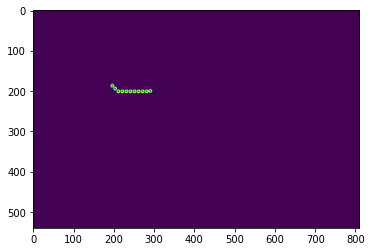

In [325]:
simple_tracker.vis()

In [144]:
H = 540
W = 810
simple_tracker = tracker(H, W)
q = torch.zeros((38,))
q[0] = 40
simple_tracker.set_init(q)
data_path = "/home/yixuan/dart_deformable/data/rope_simple/"
for i in range(251):
    rgb_np = exr_to_np(data_path+"rgb_"+'{0:03d}'.format(i)+".exr")
    mask = rgb_np[:, :, 2] > 100
    simple_tracker.set_obs(torch.tensor(mask), rgb_np)
    simple_tracker.step()
    simple_tracker.vis()

---- optimize translation ----
loss: tensor(3.7392e+08, grad_fn=<SumBackward0>)
tensor([ 40.1525, 264.1602,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000])
tensor([-1.6340e+03, -2.8302e+06,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.000

KeyboardInterrupt: 

In [259]:
H = 540
W = 810
simple_tracker = tracker(H, W, cuda=True)

In [263]:
q = torch.zeros((10,)).cuda()
mask = torch.zeros((H, W), dtype=bool)
mask[200:205, 200:300] = True
simple_tracker.set_obs(mask)
simple_tracker.set_init(q)
J=jacobian(simple_tracker.dist_fn, q)
dist=simple_tracker.dist_fn(q)

In [264]:
torch.mm(J.t(), dist.unsqueeze(1))

tensor([[  -84750.],
        [ -168500.],
        [-1685000.],
        [-1685000.],
        [-1685000.],
        [-1685000.],
        [-1685000.],
        [-1685000.],
        [-1685000.],
        [-1685000.]], device='cuda:0')

In [265]:
simple_tracker.step()

---- optimize translation ----
loss: tensor(71567256., grad_fn=<SumBackward0>)
tensor([ 169.5000,  337.0000, 3370.0002, 3370.0002, 3370.0002, 3370.0002,
        3370.0002, 3370.0002, 3370.0002, 3370.0002], device='cuda:0')
tensor([ -169500.,  -337000., -3370000., -3370000., -3370000., -3370000.,
        -3370000., -3370000., -3370000., -3370000.], device='cuda:0')


KeyboardInterrupt: Interrupted by user

In [228]:
mask = torch.zeros((H, W), dtype=bool)
mask[200:205, 200:300] = True
N = mask.nonzero().shape[0]
n = 100
rand_idx = np.random.choice(N, n)
sub = torch.zeros_like(mask)
print(mask.nonzero()[rand_idx])
sub[mask.nonzero()[rand_idx][:, 0], mask.nonzero()[rand_idx][:, 1]] = True

tensor([[200, 238],
        [201, 296],
        [203, 244],
        [201, 293],
        [203, 231],
        [203, 219],
        [202, 209],
        [204, 284],
        [202, 238],
        [200, 208],
        [201, 209],
        [204, 210],
        [202, 243],
        [204, 221],
        [200, 208],
        [204, 289],
        [203, 209],
        [201, 263],
        [203, 265],
        [201, 250],
        [204, 232],
        [201, 228],
        [202, 243],
        [204, 200],
        [200, 226],
        [201, 270],
        [203, 202],
        [203, 275],
        [201, 213],
        [200, 220],
        [201, 239],
        [203, 259],
        [200, 243],
        [203, 268],
        [200, 257],
        [204, 282],
        [200, 229],
        [202, 270],
        [203, 235],
        [201, 289],
        [200, 284],
        [203, 281],
        [204, 275],
        [201, 222],
        [201, 290],
        [200, 229],
        [200, 288],
        [201, 200],
        [200, 287],
        [201, 297],


In [229]:
sub.sum()

tensor(91)

In [204]:
sub.nonzero()

tensor([[200,   0],
        [200,   1],
        [200,   2],
        ...,
        [299, 807],
        [299, 808],
        [299, 809]])

In [206]:
mask.nonzero()[rand_idx[:, 0], rand_idx[:, 1]]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [212]:
torch.index_select(mask, 0, mask.nonzero()[rand_idx][:, 0]).shape

torch.Size([100, 810])

In [210]:
rand_idx

array([445, 416, 425, 157, 350, 461, 222, 250, 463, 320,   9,  81, 119,
       440, 493,  56,  49, 140, 384, 204, 333, 285, 158, 115, 299, 255,
        20, 240, 231, 372,  29, 188, 324, 376, 230, 184, 361,  37, 181,
       434, 351, 414, 191, 339, 182,   8, 342, 284, 336, 104, 262,   0,
       327, 285, 476, 184,  72, 162,  81, 243, 455, 202, 316, 332,  11,
       156,  68, 370,  22, 242, 371,   1, 349, 456, 499, 126,   7,  81,
       184, 295, 150, 371,  57, 365,  29, 281, 451, 417, 170, 400, 402,
       373,  42, 242, 110, 410, 215, 466, 363, 271])

In [214]:
sub[[1, 2], [2, 2]]

tensor([False, False])